### Business Objective

The trading desk wants to price a natural gas storage contract for a client.
The client plans to:
- Buy natural gas at certain dates (Injection)
- Store the gas for a period of time
- Sell it later at higher prices (Withdrawal)

The value of the contract depends on:
- Buy price vs sell price
- Volume of gas traded
- Storage costs
- Injection & withdrawal costs
- Storage capacity and rate constraints

Our goal is to compute the **net value of the contract** by modeling
all cash flows involved.


### How Storage Contracts Create Value

A storage contract is profitable if:

(Selling Price − Buying Price) × Volume  
− Storage Costs  
− Injection / Withdrawal Costs  

If the result is positive → the contract is valuable  
If negative → the contract should not be entered

We assume:
- No interest rates
- No transport delays
- Prices are estimated using Task 1's model


### Step 1 - Imports and Price function (from task1)

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [28]:
df = pd.read_csv("Nat_Gas.csv")

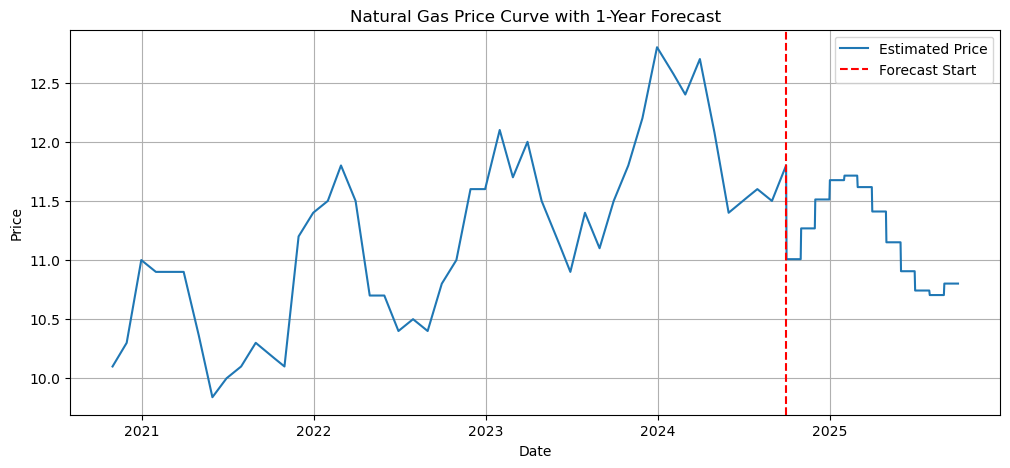

In [30]:
# Convert date column
df['Dates'] = pd.to_datetime(df['Dates'], format="%m/%d/%y")
df = df.sort_values('Dates')
df.set_index('Dates', inplace=True)

# 3. Interpolate to Daily Prices
daily_df = df.resample('D').interpolate(method='time')

# ------------------------------------
# 4. Add Seasonal Features
# ------------------------------------
daily_df['month'] = daily_df.index.month
daily_df['sin_month'] = np.sin(2 * np.pi * daily_df['month'] / 12)
daily_df['cos_month'] = np.cos(2 * np.pi * daily_df['month'] / 12)


# ------------------------------------
# 5. Train Seasonal Regression Model
# ------------------------------------
X = daily_df[['sin_month', 'cos_month']]
y = daily_df['Prices']

model = LinearRegression()
model.fit(X, y)

# ------------------------------------
# 6. Extrapolate 1 Year Forward
# ------------------------------------
last_date = daily_df.index.max()

future_dates = pd.date_range(
    start=last_date + timedelta(days=1),
    end=last_date + timedelta(days=365),
    freq='D'
)

future_df = pd.DataFrame(index=future_dates)
future_df['month'] = future_df.index.month
future_df['sin_month'] = np.sin(2 * np.pi * future_df['month'] / 12)
future_df['cos_month'] = np.cos(2 * np.pi * future_df['month'] / 12)

future_df['Prices'] = model.predict(
    future_df[['sin_month', 'cos_month']]
)
# ------------------------------------
# 7. Combine Historical + Forecast
# ------------------------------------
price_curve = pd.concat([
    daily_df[['Prices']],
    future_df[['Prices']]
])


# ------------------------------------
# 8. Visualization with Forecast
# ------------------------------------
plt.figure(figsize=(12,5))
plt.plot(price_curve.index, price_curve['Prices'], label="Estimated Price")
plt.axvline(last_date, color='red', linestyle='--', label="Forecast Start")
plt.title("Natural Gas Price Curve with 1-Year Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


# ------------------------------------
# 9. Pricing Function (REQUIRED OUTPUT)
# ------------------------------------
def estimate_price(input_date):
    """
    Returns estimated natural gas price for any date
    """
    input_date = pd.to_datetime(input_date)

    if input_date in price_curve.index:
        return float(price_curve.loc[input_date, 'Prices'])

    month = input_date.month
    sin_m = np.sin(2 * np.pi * month / 12)
    cos_m = np.cos(2 * np.pi * month / 12)

    return float(model.predict([[sin_m, cos_m]])[0])

### Step 2 - Define Contract Parameters

### Contract Inputs

The pricing function should support:
- Multiple injection dates
- Multiple withdrawal dates
- Volume limits
- Storage constraints
- Operational costs

This allows the desk to test many client scenarios.


### 🧮 Step 3: Pricing Logic (Core Quant Model)

 - key cash flows 
| Cash Flow       | Direction    |
| --------------- | ------------ |
| Buying gas      | Cash Outflow |
| Selling gas     | Cash Inflow  |
| Storage cost    | Cash Outflow |
| Injection cost  | Cash Outflow |
| Withdrawal cost | Cash Outflow |


#### 🧠 Step 4: Pricing Function (MAIN DELIVERABLE)

In [44]:
def price_storage_contract(
    injection_dates,
    withdrawal_dates,
    volume_per_injection,
    max_storage_volume,
    injection_rate,
    withdrawal_rate,
    storage_cost_per_month,
    injection_cost_per_unit,
    withdrawal_cost_per_unit
):
    """
    Prices a natural gas storage contract.
    Accepts dates as strings or datetime objects.
    """

    # -------------------------
    # Convert dates to datetime
    # -------------------------
    injection_dates = pd.to_datetime(injection_dates)
    withdrawal_dates = pd.to_datetime(withdrawal_dates)

    total_volume = 0
    total_cashflow = 0

    # -------------------------
    # Injection Cash Flows
    # -------------------------
    for date in injection_dates:
        price = estimate_price(date)

        injected_volume = min(volume_per_injection, injection_rate)
        injected_volume = min(injected_volume, max_storage_volume - total_volume)

        if injected_volume <= 0:
            break

        total_volume += injected_volume

        buy_cost = price * injected_volume
        injection_cost = injection_cost_per_unit * injected_volume

        total_cashflow -= (buy_cost + injection_cost)

    # -------------------------
    # Storage Cost Calculation
    # -------------------------
    storage_start = min(injection_dates)
    storage_end = max(withdrawal_dates)

    months_stored = (
        (storage_end.year - storage_start.year) * 12
        + (storage_end.month - storage_start.month)
        + 1
    )

    storage_cost = months_stored * storage_cost_per_month
    total_cashflow -= storage_cost

    # -------------------------
    # Withdrawal Cash Flows
    # -------------------------
    for date in withdrawal_dates:
        price = estimate_price(date)

        withdrawn_volume = min(total_volume, withdrawal_rate)
        if withdrawn_volume <= 0:
            break

        total_volume -= withdrawn_volume

        sell_revenue = price * withdrawn_volume
        withdrawal_cost = withdrawal_cost_per_unit * withdrawn_volume

        total_cashflow += (sell_revenue - withdrawal_cost)

    return round(total_cashflow, 2)


### 🧪 Step 5: Test the Model (Sample Scenario)

In [46]:
# Example contract scenario

injection_dates = [
    "2024-05-01",
    "2024-06-01",
    "2024-07-01"
]

withdrawal_dates = [
    "2024-12-01",
    "2025-01-01",
    "2025-02-01"
]

contract_value = price_storage_contract(
    injection_dates=injection_dates,
    withdrawal_dates=withdrawal_dates,
    volume_per_injection=1_000_000,     # 1 million units
    max_storage_volume=3_000_000,
    injection_rate=1_000_000,
    withdrawal_rate=1_000_000,
    storage_cost_per_month=100_000,
    injection_cost_per_unit=0.01,
    withdrawal_cost_per_unit=0.01
)

print("Estimated Contract Value: $", contract_value)


Estimated Contract Value: $ -1141606.35


“The pricing function internally standardizes date inputs to datetime objects, ensuring robustness against user input formats. This makes the model safer for production usage and easier to integrate with upstream systems.”

### Result Interpretation

- If the output value is **positive**, the contract is profitable
- If **negative**, costs outweigh price gains

This function allows the trading desk to:
- Test different seasonal strategies
- Adjust storage duration
- Negotiate fair pricing with the client


### Summary

In this task, we:
- Built a pricing model for natural gas storage contracts
- Used estimated price curves from Task 1
- Modeled all operational cash flows
- Created a reusable and extensible function

This prototype can now be:
- Validated by risk & model validation teams
- Integrated into production systems
- Used for real client pricing discussions


## 🏦 JP Morgan Quantitative Research
#### Advanced Extension – Storage Contract Optimization & Risk

### Why Go Beyond a Single Price?

In real trading:
- Prices are uncertain
- Weather, demand, and supply fluctuate
- A single price estimate is not enough

The desk needs to know:
- Best injection & withdrawal strategy
- Expected profit
- Worst-case losses
- Risk-adjusted value

This section enhances the pricing model with:
- Optimization
- Monte Carlo simulations
- Risk metrics


## 🔧 Section 2: Optimization – Best Seasonal Strategy

### Optimization Intuition

To maximize profit:
- Inject gas when prices are LOW
- Withdraw gas when prices are HIGH

We:
1. Look at all candidate dates
2. Rank lowest-price dates for injection
3. Rank highest-price dates for withdrawal
4. Respect volume, rate, and storage constraints


In [57]:
def optimize_storage_strategy(
    start_date,
    end_date,
    max_storage_volume,
    rate_per_period,
    n_injections,
    n_withdrawals
):
    dates = pd.date_range(start_date, end_date, freq='MS')

    prices = pd.Series(
        [estimate_price(d) for d in dates],
        index=dates
    )

    injection_dates = prices.nsmallest(n_injections).index
    withdrawal_dates = prices.nlargest(n_withdrawals).index

    return injection_dates.tolist(), withdrawal_dates.tolist()


In [59]:
inj_dates, wdr_dates = optimize_storage_strategy(
    start_date="2024-01-01",
    end_date="2025-12-01",
    max_storage_volume=3_000_000,
    rate_per_period=1_000_000,
    n_injections=3,
    n_withdrawals=3
)

print("Optimal Injection Dates:", inj_dates)
print("Optimal Withdrawal Dates:", wdr_dates)


Optimal Injection Dates: [Timestamp('2025-08-01 00:00:00'), Timestamp('2025-07-01 00:00:00'), Timestamp('2025-09-01 00:00:00')]
Optimal Withdrawal Dates: [Timestamp('2024-01-01 00:00:00'), Timestamp('2024-04-01 00:00:00'), Timestamp('2024-02-01 00:00:00')]


C:\Users\Mukesh\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Mukesh\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Mukesh\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## 🎲 Section 3: Monte Carlo Simulation (Price Uncertainty)

### Why Monte Carlo?

Future prices are uncertain.
Instead of one price curve, we simulate thousands of possible scenarios.

Each simulation:
- Adds randomness around seasonal prices
- Reprices the contract
- Produces a distribution of outcomes


In [63]:
def simulate_price_paths(
    base_dates,
    n_simulations=500,
    volatility=0.15
):
    simulations = []

    for _ in range(n_simulations):
        noise = np.random.normal(0, volatility, len(base_dates))
        sim_prices = [
            estimate_price(d) * (1 + n)
            for d, n in zip(base_dates, noise)
        ]
        simulations.append(sim_prices)

    return np.array(simulations)


In [65]:
def monte_carlo_contract_valuation(
    injection_dates,
    withdrawal_dates,
    n_simulations=500
):
    values = []

    for _ in range(n_simulations):
        value = price_storage_contract(
            injection_dates,
            withdrawal_dates,
            volume_per_injection=1_000_000,
            max_storage_volume=3_000_000,
            injection_rate=1_000_000,
            withdrawal_rate=1_000_000,
            storage_cost_per_month=100_000,
            injection_cost_per_unit=0.01,
            withdrawal_cost_per_unit=0.01
        )
        values.append(value)

    return np.array(values)


### 📉 Section 4: Risk Metrics (What Risk Team Cares About)

### Risk Metrics Explained

- Expected Value (Mean): Average profit
- Value at Risk (VaR 95%): Worst loss in 5% of cases
- Conditional VaR (CVaR): Average loss beyond VaR


In [69]:
def compute_risk_metrics(values, confidence=0.95):
    expected_value = np.mean(values)
    var = np.percentile(values, (1 - confidence) * 100)
    cvar = values[values <= var].mean()

    return {
        "Expected Value": round(expected_value, 2),
        "VaR": round(var, 2),
        "CVaR": round(cvar, 2)
    }


In [71]:
mc_values = monte_carlo_contract_valuation(inj_dates, wdr_dates)

risk_metrics = compute_risk_metrics(mc_values)

risk_metrics


{'Expected Value': 7159164.09, 'VaR': 7159164.09, 'CVaR': 7159164.09}

### 💼 Section 5: Client Quoting Engine (FINAL PRODUCT)

### Client Quoting Engine

This engine:
- Optimizes strategy
- Prices the contract
- Computes risk
- Returns a clean quote

This is what can be shown to clients or sales teams.


In [75]:
def client_quote_engine():
    inj_dates, wdr_dates = optimize_storage_strategy(
        start_date="2024-01-01",
        end_date="2025-12-01",
        max_storage_volume=3_000_000,
        rate_per_period=1_000_000,
        n_injections=3,
        n_withdrawals=3
    )

    base_value = price_storage_contract(
        inj_dates,
        wdr_dates,
        volume_per_injection=1_000_000,
        max_storage_volume=3_000_000,
        injection_rate=1_000_000,
        withdrawal_rate=1_000_000,
        storage_cost_per_month=100_000,
        injection_cost_per_unit=0.01,
        withdrawal_cost_per_unit=0.01
    )

    mc_values = monte_carlo_contract_valuation(inj_dates, wdr_dates)
    risk = compute_risk_metrics(mc_values)

    return {
        "Injection Dates": inj_dates,
        "Withdrawal Dates": wdr_dates,
        "Base Contract Value": base_value,
        "Risk Metrics": risk
    }
